In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ModelCheckpoint, Callback


In [ ]:
# Dataset 2 Paths
dataset1_benign = '/content/drive/MyDrive/siar/Siar-dataset/Normal'
dataset1_malignant = '/content/drive/MyDrive/siar/Siar-dataset/Tumor'
IMG_SIZE = 224

def load_and_normalize_images(folder):
    images = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            img = img.astype('float32') / 255.0
            images.append(img)
    return images

# Load images
images_benign = load_and_normalize_images(dataset1_benign)
images_malignant = load_and_normalize_images(dataset1_malignant)


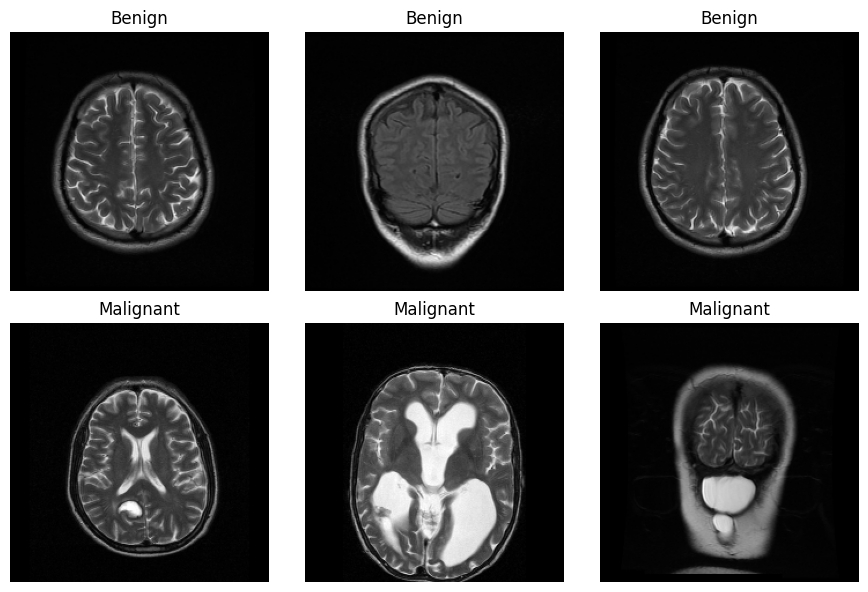

In [ ]:
def display_samples(benign_images, malignant_images, num_samples=3):
    plt.figure(figsize=(num_samples * 3, 6))

    for i in range(num_samples):
        plt.subplot(2, num_samples, i + 1)
        plt.imshow(benign_images[i], cmap='gray')
        plt.title("Benign")
        plt.axis('off')

    for i in range(num_samples):
        plt.subplot(2, num_samples, num_samples + i + 1)
        plt.imshow(malignant_images[i], cmap='gray')
        plt.title("Malignant")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

display_samples(images_benign, images_malignant)


In [ ]:
# Labels: 0 = Benign, 1 = Malignant
labels_benign = [0] * len(images_benign)
labels_malignant = [1] * len(images_malignant)

# Combine and convert
X = np.array(images_benign + images_malignant).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
X = np.repeat(X, 3, axis=-1)  # Grayscale → 3 channels
y = np.array(labels_benign + labels_malignant)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)


In [ ]:
def build_finetuned_resnet():
    base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))

    # Unfreeze last 30 layers
    for layer in base_model.layers[:-30]:
        layer.trainable = False
    for layer in base_model.layers[-30:]:
        layer.trainable = True

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = Dropout(0.4)(x)
    x = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = Dropout(0.3)(x)
    output = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

model = build_finetuned_resnet()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,136,961 (92.08 MB)

 Trainable params: 14,995,329 (57.20 MB)

 Non-trainable params: 9,141,632 (34.87 MB)

In [ ]:
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_test, y_test)
)

In [ ]:
# Plotting the accuracy and loss for Dataset 2
plt.figure(figsize=(12, 6))

# Accuracy Graph for Dataset 2
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy -  Brain Tumor MRI')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss Graph for Dataset 2
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss - Brain Tumor MRI')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Function to plot the confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion Matrix'):
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Evaluate the model
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype("int32")

y_true = y_test

In [ ]:
# Confusion Matrix for Dataset 2
cm2 = confusion_matrix(y_true, y_pred_classes)
plot_confusion_matrix(cm2, classes=['Benign', 'Malignant'], title='Confusion Matrix - Brain Tumor Detection')

In [ ]:
# Path to the image you want to test
image_path = '' # Replace with your image path

# Load and preprocess the image
img_to_test = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
if img_to_test is not None:
    img_to_test = cv2.resize(img_to_test, (128, 128))
    img_to_test = img_to_test.astype('float32') / 255.0  # Normalize to [0, 1]
    img_to_test = np.expand_dims(img_to_test, axis=0)  # Add batch dimension
    img_to_test = np.repeat(img_to_test, 3, axis=-1)  # Convert grayscale to 3-channel

    # Ensure the shape is correct for prediction
    img_to_test = np.reshape(img_to_test, (1, 128, 128, 3))


    # Make a prediction
    prediction = model.predict(img_to_test)

    # Determine the predicted class based on the sigmoid output
    predicted_class_index = (prediction > 0.5).astype("int32")[0][0]
    predicted_class = 'Malignant' if predicted_class_index == 1 else 'Benign'

    print(f"The predicted class for the image is: {predicted_class}")

else:
    print(f"Could not load image from {image_path}")